# ARMA(p,q) and ARIMA(p,d,q)
# Autoregressive Moving Averages
This section covers <em>Autoregressive Moving Averages</em> (ARMA) and <em>Autoregressive Integrated Moving Averages</em> (ARIMA).

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html'>arima_model.ARMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Moving Average ARMA(p,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.html'>arima_model.ARMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;Class to hold results from fitting an ARMA model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html'>arima_model.ARIMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Integrated Moving Average ARIMA(p,d,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.html'>arima_model.ARIMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;Class to hold results from fitting an ARIMA model<br>	
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.kalmanf.kalmanfilter.KalmanFilter.html'>kalmanf.kalmanfilter.KalmanFilter</a></strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kalman Filter code intended for use with the ARMA model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive–moving-average model</font><br>
<strong>
<a href='https://otexts.com/fpp2/non-seasonal-arima.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Non-seasonal ARIMA models</font></div>

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for determining (p, q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load daily female births dataset (which is a stationary series)
births = pd.read_csv("D:/ML-Datasets/Udemy-TimeSeries/DailyTotalFemaleBirths.csv", index_col='Date', parse_dates=True)
births.index.freq = 'D'
#births = births[:120]  # we only want the first four months

# Load trade inventories dataset (which has seasonality)
trade = pd.read_csv("D:/ML-Datasets/Udemy-TimeSeries/TradeInventories.csv", index_col='Date', parse_dates=True)
trade.index.freq = 'MS'

### Plot the source data

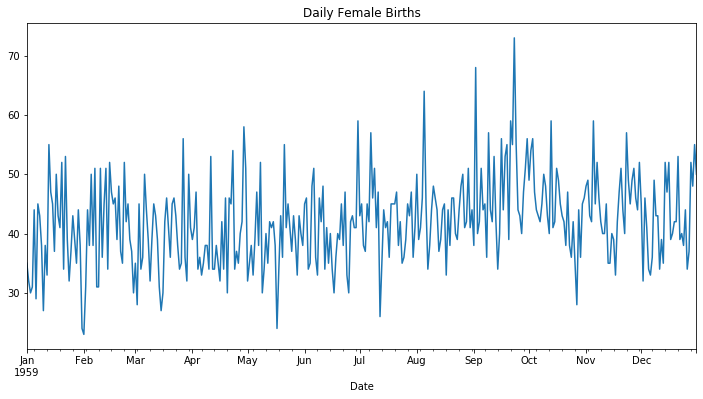

In [2]:
# Lets visualize the series
births['Births'].plot(figsize=(12, 6), title='Daily Female Births');

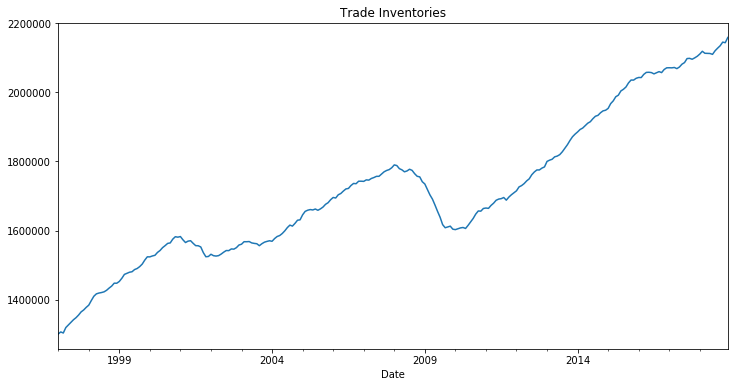

In [3]:
trade['Inventories'].plot(figsize=(12, 6), title='Trade Inventories');

## Automate the augmented Dickey-Fuller Test
Since we'll be using it a lot to determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## Autoregressive Moving Average - ARMA(p,q)
In this first section we'll look at a stationary dataset, determine (p,q) orders, and run a forecasting ARMA model fit to the data. In practice it's rare to find stationary data with no trend or seasonal component, but the first four months of the <em>Daily Total Female Births</em> dataset should work for our purposes.

### Run the augmented Dickey-Fuller Test to confirm stationarity

In [5]:
adf_test(births['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Determine the (p,q) ARMA Orders using <tt>pmdarima.auto_arima</tt>
This tool should give just $p$ and $q$ value recommendations for this dataset.

In [6]:
auto_arima(births['Births'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.077
Date:                Sat, 04 Apr 2020   AIC                           2460.154
Time:                        17:32:34   BIC                           2475.743
Sample:                             0   HQIC                          2466.350
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0132      0.014      0.975      0.330      -0.013       0.040
ar.L1          0.1299      0.059      2.217      0.027       0.015       0.245
ma.L1         -0.9694      0.016    -62.235      0.000      -1.000      -0.939
sigma2        48.9989      3.432     14.279      0.000      42.273      55.725
===================================================================================
Ljung-Box (Q):                       36.69   Jarque-Bera (JB):                26.17
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.58
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets
As a general rule you should set the length of your test set equal to your intended forecast size. For this dataset we'll attempt a 1-month forecast.

In [7]:
# Set one month for testing
train = births.iloc[:335]
test = births.iloc[335:]

### Fit an ARMA(p,q) Model
If you want you can run <tt>help(ARMA)</tt> to learn what incoming arguments are available/expected, and what's being returned.

In [8]:
model = ARMA(train['Births'], order=(2, 2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                  335
Model:                     ARMA(2, 2)   Log Likelihood               -1127.590
Method:                       css-mle   S.D. of innovations              6.982
Date:                Sat, 04 Apr 2020   AIC                           2267.180
Time:                        17:32:34   BIC                           2290.065
Sample:                    01-01-1959   HQIC                          2276.304
                         - 12-01-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.9156      1.529     27.413      0.000      38.919      44.913
ar.L1.Births     0.0161      0.032      0.502      0.615      -0.047       0.079
ar.L2.Births     0.9465      0.029     32.738      0.000       0.890       1.003
ma.L1.Births     0.0835      0.066      1.270      0.204      -0.045       0.212
ma.L2.Births    -0.9165      0.066    -13.958      0.000      -1.045      -0.788
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0194           +0.0000j            1.0194            0.0000
AR.2           -1.0364           +0.0000j            1.0364            0.5000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0911           +0.0000j            1.0911            0.0000
-----------------------------------------------------------------------------
"""

### Obtain a month's worth of predicted values

In [9]:
predictions = results.predict(start=len(train), end=len(births)-1).rename('ARMA(2, 2) Predictions')

### Plot predictions against known values

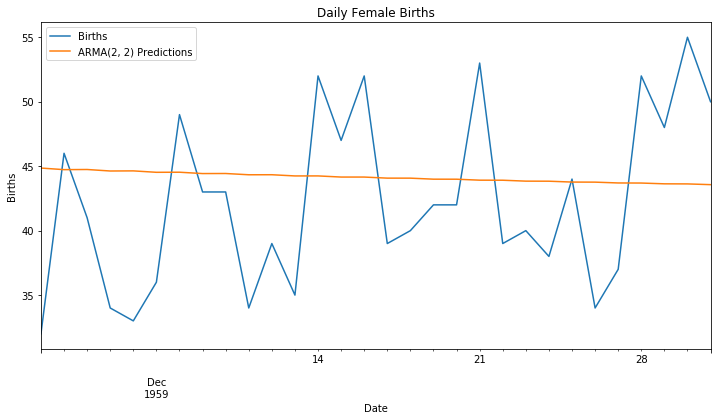

In [10]:
test['Births'].plot(figsize=(12, 6), legend=True, title='Daily Female Births')
predictions.plot(legend=True).autoscale(axis='x', tight=True)
plt.ylabel("Births");

Since our starting dataset exhibited no trend or seasonal component, this prediction makes sense. In the next section we'll take additional steps to evaluate the performance of our predictions, and forecast into the future.

In [11]:
# Comparing the mean
print(f"Mean of the test set : {test['Births'].mean()}")
print(f"Mean of the predictions set : {predictions.mean()}")

Mean of the test set : 42.3
Mean of the predictions set : 44.1449454704942


### We will plot the inventories dataset

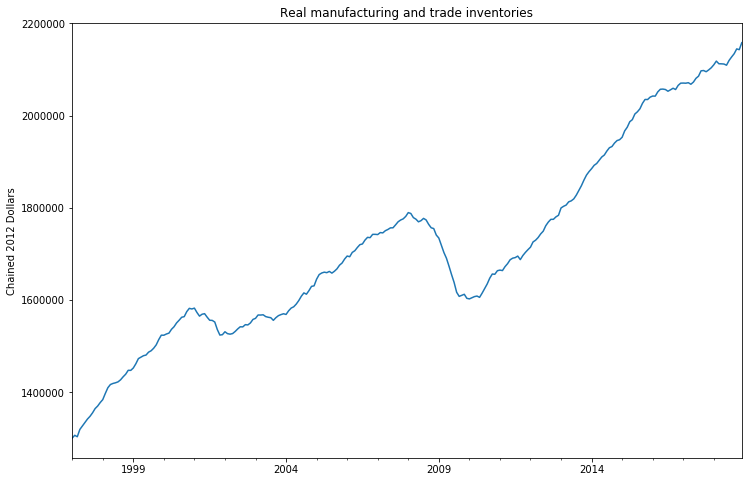

In [16]:
import matplotlib.ticker as ticker

formatter = ticker.StrMethodFormatter('{x:, .0f}')

title = 'Real manufacturing and trade inventories'
ylabel = 'Chained 2012 Dollars'
xlabel = ''

ax = trade['Inventories'].plot(figsize=(12, 8), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

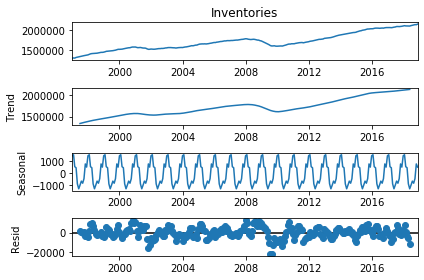

In [17]:
# We will run an ETS decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(trade['Inventories'], model='additive')
result.plot();

This shows, that series has a seasonal component, but the seasonal values are too samll as compared to trend values and hence for this lecture, we choose not to run a SARIMA model

Here we see that the seasonal component does not contribute significantly to the behavior of the series.
### Use <tt>pmdarima.auto_arima</tt> to determine ARIMA Orders

In [20]:
auto_arima(trade['Inventories'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Sat, 04 Apr 2020   AIC                           5348.037
Time:                        17:41:25   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Although this suggests, we should fit a SARIMAX(0, 1, 0) model, but just for this exercise we would fit an an ARIMA(1,1,1) model to best forecast future values of the series. 

Before we train the model, let's look at augmented Dickey-Fuller Test, and the ACF/PACF plots to see if they agree. These steps are optional, and we would likely skip them in practice.

### Run the augmented Dickey-Fuller Test on the First Difference

In [22]:
from statsmodels.tsa.statespace.tools import diff
trade['d1'] = diff(trade['Inventories'], k_diff=1)

adf_test(trade['d1'], 'Real manufacturing and trade inventories')

Augmented Dickey-Fuller Test: Real manufacturing and trade inventories
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This confirms that we reached stationarity after the first difference.
### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

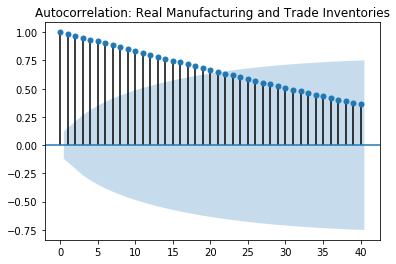

In [23]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(trade['Inventories'],title=title,lags=lags);

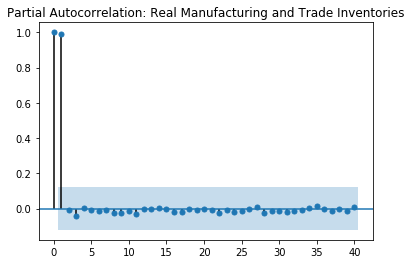

In [24]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(trade['Inventories'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms. The lag at which the PACF cuts off is the indicated number of AR terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [25]:
stepwise_fit = auto_arima(trade['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=5348.037, BIC=5355.181, Time=0.011 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=5399.843, BIC=5410.560, Time=0.042 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=5350.241, BIC=5360.957, Time=0.033 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=5409.217, BIC=5412.789, Time=0.008 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=5378.835, BIC=5393.124, Time=0.126 seconds
Total fit time: 0.221 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Sat, 04 Apr 2020   AIC                           5348.037
Time:                        17:49:11   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks good from here! As communicated earlier Now let's train & test the ARIMA(1,1,1) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [26]:
# Set one year for testing
train = trade.iloc[:252]
test = trade.iloc[252:]

### Fit an ARIMA(1,1,1) Model

In [27]:
model = ARIMA(train['Inventories'], order=(1, 1, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.394
Method:                       css-mle   S.D. of innovations           4845.003
Date:                Sat, 04 Apr 2020   AIC                           4980.787
Time:                        17:57:01   BIC                           4994.889
Sample:                    02-01-1997   HQIC                          4986.462
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3249.0071   1345.095      2.415      0.016     612.669    5885.345
ar.L1.D.Inventories     0.9026      0.039     23.012      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1079           +0.0000j            1.1079            0.0000
MA.1            1.7917           +0.0000j            1.7917            0.0000
-----------------------------------------------------------------------------
"""

In [33]:
# Obtain predicted values
predictions = results.predict(start=len(train), end=len(trade)-1, dynamic=False, 
                              typ='levels').rename('ARIMA(1, 1, 1) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [34]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Inventories'][i]}")

predicted=2107159.643, expected=2110158
predicted=2110552.733, expected=2118199
predicted=2113931.785, expected=2112427
predicted=2117298.168, expected=2112276
predicted=2120653.115, expected=2111835
predicted=2123997.741, expected=2109298
predicted=2127333.051, expected=2119618
predicted=2130659.953, expected=2127170
predicted=2133979.265, expected=2134172
predicted=2137291.729, expected=2144639
predicted=2140598.009, expected=2143001
predicted=2143898.71 , expected=2158115


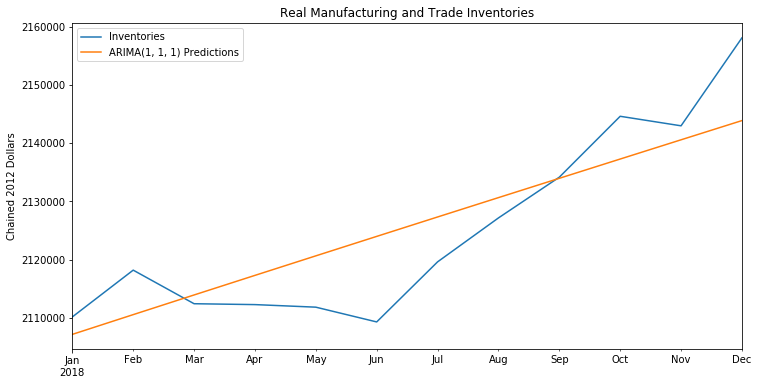

In [35]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the Model

In [36]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

error = mean_squared_error(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

error = rmse(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 60198518.06
ARIMA(1,1,1) RMSE Error: 7758.770396


### Retrain the model on the full data, and forecast the future

In [39]:
model = ARIMA(trade['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(trade),len(trade)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

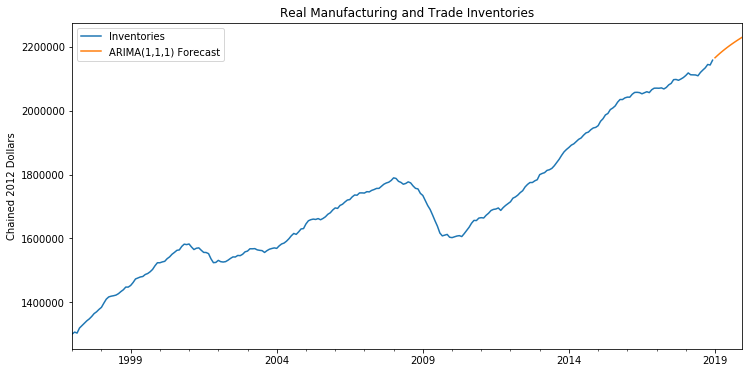

In [41]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = trade['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);